# <center> IESO ML Project </center>

<center> notebook four <br> Logistic Regression, <br> <br> Upsampling and<br> HyperParameter Optimization</center>

Prepared by Behrouz ShakeriFard <br>

email: bshakeri@torontomu.ca <br>
April 2024

<hr>

In the previous notebooks, we spent some time cleaning the data, exploring variables and their relationships, examining the correlation coefficients with our target (price), and finally we did principal component analysis. Now, we want to arrive at a better definition of our target variable, and get started with the real stuff: machine learning!

## Defining the Challenge

In short, we would like to predict *when* a variable (price) goes beyong a certain point. This is the primary challenge. The rest of this notebook addresses two questions:

1. Where is that threshhold, beyond which the price is not only high, but *too* high?

2. How do we predict that spike? In other words, which features of the data are useful for predicting the target (which, in this case is binary)?

##### Why is this project useful?

This analysis seeks to identify the best machine learning technique for predicting a binary outcome, which we will construct using the IESO data. This binary outcome indicates when a building (residential or commercial) equipped with adequate electricity storage would disengage from the electricity grid, in order to stop buying electricity from the grid.

This is useful because large fluctuations in price - in particular during peak hours - can become heavy financial burdens for large consumers (such as apartment blocks or commercial plants for food processing, manufacturing, assembly, or other activities).
<hr>


But first, let's import a few useful packages, as well as our data.


In [1]:
# importing a few useful packages
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import style

In [3]:
# Let's import our data
df = pd.read_csv('df_ieso_cleaned_2021.csv')

In [4]:
new_features_df = pd.read_csv('New Features IESO ML 2024.csv')

In [5]:
# sanity cehck

df.head()

,Unnamed: 0,Date Time,Market Demand,Ontario Demand,HOEP,Output,capability
0,0,2021-01-01 01:00:00,16057,14112,31.74,14301.0,26203.0
1,1,2021-01-01 02:00:00,15516,13504,17.61,13786.0,26494.0
2,2,2021-01-01 03:00:00,15185,13155,14.36,13507.0,26587.0
3,3,2021-01-01 04:00:00,14940,12892,10.26,13505.0,26749.0
4,4,2021-01-01 05:00:00,14802,12798,6.03,12881.0,26843.0


In [6]:
# Some clean-up is due
df.drop('Unnamed: 0', inplace=True, axis=1)

In [7]:
df.index = pd.to_datetime(df['Date Time'])
df.drop('Date Time', inplace=True, axis=1)

In [8]:
df.dtypes

Market Demand       int64
Ontario Demand      int64
HOEP              float64
Output            float64
capability        float64
dtype: object

In [9]:
# sanity check
new_features_df.head()

,Unnamed: 0,2021 Demand,Annual Surplus,Output/Cap,Market Surplus
0,0,14112,-893,0.545777,189.0
1,1,13504,-609,0.520344,282.0
2,2,13155,-601,0.508030,352.0
3,3,12892,-532,0.504879,613.0
4,4,12798,-445,0.479864,83.0


In [10]:
new_features_df.drop('Unnamed: 0', axis=1, inplace=True)

Cool.

Now we can get started with further examining our target: HOEP.

<hr>

## The Target

Setting a point (a threshhold) beyond which we would consider a price increase to be a *spike* (in other words, the threshhold beyond which our binary target would become TRUE) requires careful consideration. Ideally, this model will be used by households and businesses that are equipped with energy storage as well (think of large lithium-ion batteries, or similar technologies). Therefore, what ever the threshhold, the frequency of occurences above it, must be fairly close to the frequency of very low prices.

This is because (as you've guessed) total sum of hours that the building is utilizing the energy storage unit (due to an anticipated price spike), should be less or at most equal to the total sum of hours during which the building is charging the storage unit. Recharging should take place when price of electricity falls below a threshhold, and it may take more time to charge the unit, than to consume the stored energy. We may start by assuming that threshhold is somewhere around $5 per MWh of energy.

We begin our investigation with visually examining the distribution of price.

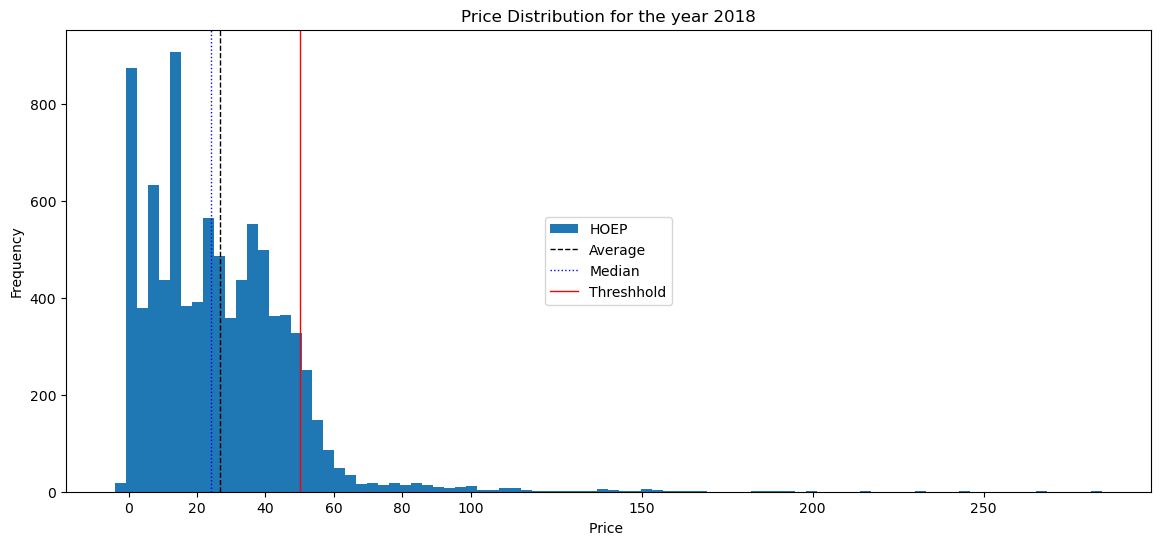

In [11]:
# initiate the plot and setting the size
plt.figure(figsize=(14,6))

# filtering values and selecting the column for our histogram
filtered_price = df[df['HOEP'] <= 300]['HOEP']
filtered_price.plot(kind='hist',bins=90)

# mean or average of the distribution
plt.axvline(df['HOEP'].mean(), color='k', linestyle='dashed', linewidth=1, label='Average')

# median of the distribution
plt.axvline(df['HOEP'].median(), color='b', linestyle=':', linewidth=1, label='Median')

# a hypothetical threshhold
plt.axvline(50, color='r', linestyle='solid', linewidth=1, label='Threshhold')

plt.xlabel('Price ')
plt.ylabel('Frequency')
plt.xticks([0,20,40,60,80,100,150,200,250])

# Title of our graph
plt.title('Price Distribution for the year 2018')
plt.legend(loc='center')
plt.show()

We can now examine the sum of all occurances above the $50 threshhold, just to see how off the mark our initial guess was.

For this, we will look at the area beneath the graph, past the threshhold.

In [12]:
# importing the integrate package in order to 
# calculate the area beneath the plot
from scipy import integrate

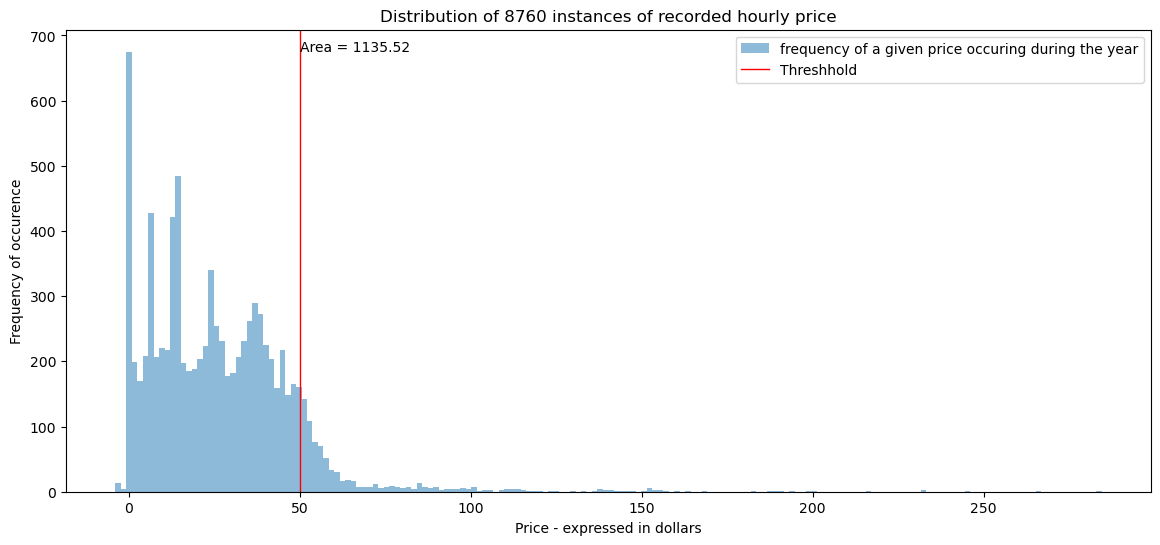

In [13]:
# initiate the plot and setting the size
plt.figure(figsize=(14,6))

# Create a histogram
plt.hist(filtered_price, bins=180, alpha=0.5, label='frequency of a given price occuring during the year')

# a hypothetical threshhol
plt.axvline(50, color='r', linestyle='solid', linewidth=1, label='Threshhold')

# Set the threshold value
threshold = 50

# Calculate the area above the threshold
hist, bin_edges = np.histogram(filtered_price, bins=180)
bin_width = bin_edges[1] - bin_edges[0]
indices_above_threshold = np.where(bin_edges[:-1] > threshold)[0]
area_above_threshold = integrate.simps(hist[indices_above_threshold], dx=bin_width)

# Add the area as a text annotation
plt.text(threshold, max(hist), f"Area = {area_above_threshold:.2f}", ha='left')

plt.xlabel('Price - expressed in dollars')
plt.ylabel('Frequency of occurence')

plt.title('Distribution of 8760 instances of recorded hourly price')

# Show the plot
plt.legend()
plt.show()

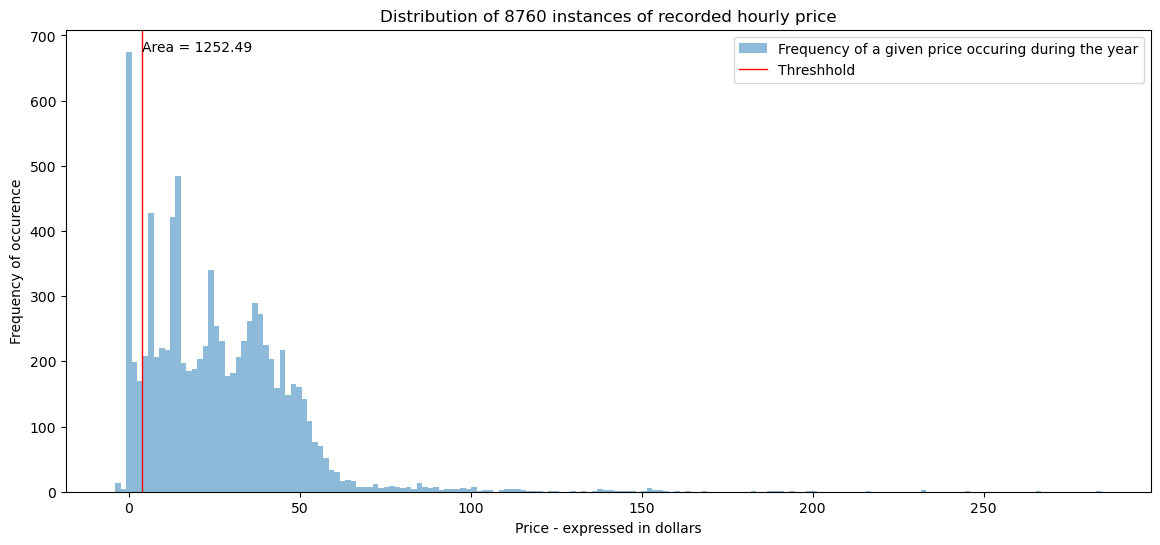

In [14]:
# initiate the plot and setting the size
plt.figure(figsize=(14,6))

# Create a histogram
plt.hist(filtered_price, bins=180, alpha=0.5, label='Frequency of a given price occuring during the year')

# a hypothetical threshhol
plt.axvline(4, color='r', linestyle='solid', linewidth=1, label='Threshhold')

# Set the threshold value
threshold = 4

# Calculate the area above the threshold
hist, bin_edges = np.histogram(filtered_price, bins=180)
bin_width = bin_edges[1] - bin_edges[0]
indices_above_threshold = np.where(bin_edges[:-1] < threshold)[0]
area_above_threshold = integrate.simps(hist[indices_above_threshold], dx=bin_width)

# Add the area as a text annotation
plt.text(threshold, max(hist), f"Area = {area_above_threshold:.2f}", ha='left')

plt.xlabel('Price - expressed in dollars')
plt.ylabel('Frequency of occurence')

plt.title('Distribution of 8760 instances of recorded hourly price')

# Show the plot
plt.legend()
plt.show()

There are two more issues that remain:

1. The need to investigate seasons independently;
2. the optimal size of energy storage unit.

We will investigate these two issues later. But for now, I will brief touch the surface of the second question because it is an interesting intellectual challenge.

The size of the battery is a function of three variables: energy consumption of the entity in question during each cycle (perhaps a 24-hr cycle), observed price fluctuations (large variance in price distribution would indicate larger storage units could yield more savings over time), the price of storage for each unit of energy they can store (and by extention of logic, useful life cycle of the unit).

Careful examination of this question is worthy of a separate notebook.

<hr>

## Target DataFrame

Our target is a binary variable, representing whether prices are normal and the client should buy electricity from the grid (this state will be represented by a False statement or Zero) or whether prics are near peak level and the client should utilize local electricity storage, in order to save money (this state will be represented by a True statement or One).

Of course, arriving at a connectivity threshold would be an optimization problem, requiring a scientific approach. However, for the moment, we will refrain from fine-tuning this variable and start with the simple exercise of creating the binary variable with a non-scientific (non-optimized) threshold, which we explored earlier in this notebook. For now, our threshhold is for defining "peak price" is $50 for each MWh of electricity.

<hr>

Let's start with creating a new dataframe for our target.

In [15]:
# new dataframe
df_target=pd.DataFrame()

# importing price
df_target['Price'] = df['HOEP']

# connect column represents a True or False (binary) variable
df_target['peak'] = df_target.apply(lambda x: int(0) if int(x['Price']) < 50 else int(1), axis=1)

In [16]:
# sanity check
df_target.sample(17,random_state=31)

,Price,peak
Date Time,,
2021-06-16 04:00:00,0.00,0
2021-06-20 11:00:00,28.58,0
2021-08-07 03:00:00,47.82,0
2021-04-13 18:00:00,7.07,0
2021-03-06 02:00:00,34.53,0
2021-02-20 04:00:00,34.94,0
2021-10-23 21:00:00,45.43,0
2021-05-18 16:00:00,20.11,0
2021-03-27 15:00:00,11.13,0


Looks good. We can move on.

In [17]:
# total instances of peak price happening
df_target['peak'].sum()

838

In [18]:
# percentage of peak occurances overal
df_target['peak'].sum()/8760 * 100

9.5662100456621

Very cool.

Let's get our hands dirty with some serious machine learning stuff!

## Features DateFrame

In [19]:
new_features_df.columns

Index(['2021 Demand', 'Annual Surplus', 'Output/Cap', 'Market Surplus'], dtype='object')

In [20]:
features_df = pd.DataFrame()

# selecting the best three features
features_df = new_features_df[['2021 Demand','Market Surplus','Output/Cap']]

<Axes: >

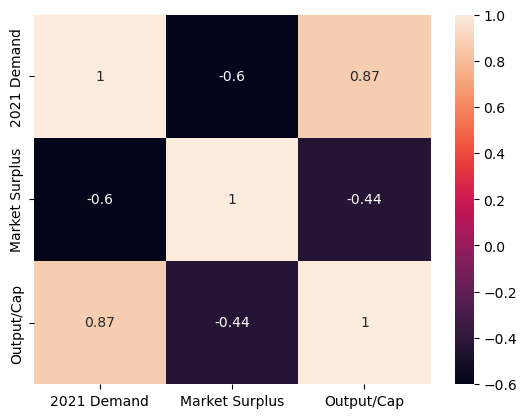

In [21]:
sns.heatmap(features_df.corr(),annot=True)

The strong correlation between <i> Output/Capacity Ratio</i> and <i> "2021 Demand" </i> is one of the weak points of our data modelling. But we soldier on!

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df_target.columns

Index(['Price', 'peak'], dtype='object')

In [24]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features_df, df_target['peak'], test_size=0.3, random_state=1)

In [25]:
y_train.sum()

600

In [26]:
y_test.sum()

238

In [27]:
len(y_train)

6132

# Logistic Regression

In [28]:
# importing the package
from sklearn.linear_model import LogisticRegression

# importing the package
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [30]:
# Fitting the linear model
LR_model = LogisticRegression(C=0.1, solver='lbfgs', max_iter=10000, random_state=42)
LR_model.fit(X_train_scaled, y_train)

print(f"The TRAIN classification accuracy is:  {LR_model.score(X_train_scaled,y_train)}")
print(f"The TEST classification accuracy is:  {LR_model.score(X_test_scaled,y_test)}")

The TRAIN classification accuracy is:  0.923679060665362
The TEST classification accuracy is:  0.9292237442922374


In order to evaluate this performance, we need to look at the confusion matrix.

In binary classification, there are four possible outcomes to making a prediction:

1. **True Positive (TP)**: Correctly predict that $x$ belongs to class 1 (Peak Price)
2. **False Positive (FP)**: Incorrectly predict that $x$  belongs to class 1 (Peak Price)
3. **True Negative (TN)**: Correctly predict $x$'s membership in class 0 (Normal Price)
4. **False Negative (FN)**: Incorrectly predict $x$'s membership in class 0 (Normal Price)

If we put these outcomes in a matrix, we arrive at what is known as a confusion matrix:

|     |  Predicted Class 0  |   Predicted Class 1  | 
| --------- |:---:|:---:|
|True Class 0|**TN** | **FP** | 
|True Class 1|**FN** |**TP** | 


In [31]:
# importing useful packages
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
y_pred = LR_model.predict(X_test)
confusion_matrix(y_test, y_pred)

/home/behroox/anaconda3/envs/ML_experiment/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[2390,    0],
       [ 238,    0]])

In [33]:
y_test.sum()

238

In [34]:
y_pred.sum()

0

In [35]:
y_train.sum()

600

In [36]:
y_train.sample()

Date Time
2021-05-01 03:00:00    0
Name: peak, dtype: int64

<hr>

Right! This is not good! <br> Our model has totally failed at predicting peak prices! Let's investigate.

In [37]:
# Get class predictions
y_pred = LR_model.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-peak", "Predicted Peak"],
    index=["True Non-Peak", "True Peak Price"]
)

display(cf_df)

/home/behroox/anaconda3/envs/ML_experiment/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Predicted Non-peak,Predicted Peak
True Non-Peak,2390,0
True Peak Price,238,0


One way of dealing with this problem, is attempting to configure the Logistic Regression so that it would address the imbalanced databy adjusting "weights" associated with the classed. Let's try this.

In [38]:
# Fitting the linear model
LR_model = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced', random_state=42)
LR_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [39]:
print(f"The TRAIN classification accuracy is:  {LR_model.score(X_train_scaled,y_train)}")
print(f"The TEST classification accuracy is:  {LR_model.score(X_test_scaled,y_test)}")

The TRAIN classification accuracy is:  0.8251793868232224
The TEST classification accuracy is:  0.8318112633181126


In [40]:
# Get class predictions
y_pred = LR_model.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-peak", "Predicted Peak"],
    index=["True Non-Peak", "True Peak Price"]
)

display(cf_df)

/home/behroox/anaconda3/envs/ML_experiment/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Predicted Non-peak,Predicted Peak
True Non-Peak,2390,0
True Peak Price,238,0


Right; that didn't help.

Let's move on to another approach: synthetic upsampling.

<hr>

## Upsampling

Our data suffers from a serious problem: our two classes are severly out of balance! Meaning, we have a lot more "False" statements in our target (peak price) and barely 10% of "True" statements. We will look into addressing this issue.

In [41]:
# upsample the credit card example
from sklearn.utils import resample

In [42]:
df_target.reset_index(inplace=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features_df, df_target['peak'], test_size = 0.3, random_state=1)

# Upsample
print('Number of class 1 examples before resampling:', X_train[y_train == 1].shape[0])

Number of class 1 examples before resampling: 600


Cool.

So, of the 8760 data points that we had, there were a total of 838 instances of 'peak price' occuring. Naturally, once we split the data into Train, Test, and Predict sub-groups, we will be dealing with a smaller group of the class of interest (peak price). 

But crucially, it is the proportion that matters most. Hence the need to resample, in order to address the under representation of the class which we are interested in predicting.

## Resample

In [44]:
X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    # this line aims to truly balance the classes, by getting the number of class 0
                                    # and repeating the resampling process until class 1 counts gets on par with class 0
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train_bal = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_bal = np.hstack((y_train[y_train == 0], y_upsampled))

Number of class 1 examples after: 5532


In [45]:
len(X_train_bal)

11064

In [46]:
len(y_train_bal)

11064

In [47]:
y_upsampled.sum()

5532

Very cool. We can move on, now that we have addressed the unbalanced target dataset.

In [48]:
X_test = X_test.values

In [49]:
# on the upsampled data
Logistic_Reg_balanced = LogisticRegression(C=0.1, random_state=42)
Logistic_Reg_balanced.fit(X_train_bal, y_train_bal)

# evaluate on the original test set - NO UPSAMPLING
y_pred_bal = Logistic_Reg_balanced.predict(X_test) 

In [50]:
print(f"The TRAIN classification accuracy is:  {Logistic_Reg_balanced.score(X_train_scaled,y_train)}")
print(f"The TEST classification accuracy is:  {Logistic_Reg_balanced.score(X_test_scaled,y_test)}")

The TRAIN classification accuracy is:  0.5357142857142857
The TEST classification accuracy is:  0.5254946727549468


In [51]:
# Get class predictions
y_pred = Logistic_Reg_balanced.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-peak", "Predicted Peak"],
    index=["True Non-Peak", "True Peak Price"]
)

display(cf_df)

,Predicted Non-peak,Predicted Peak
True Non-Peak,1379,1011
True Peak Price,50,188


This is a marked improvement!

True Positives (TP) in this case (after up-sampling) are now 188 instances. Previously they were ZERO. There are over a thousand instances of False Positives (FP). But this is not concerning, because false positives in this case do not cost us anything. The only remaining issue, is the False Negative (a total of 50) here, which unfortunately is going to be costly in our business case.

Next, we can move on to HyperParameter Optimization.

<hr>

## Hyper-parameter optimization

For this step, we need further split our data: about 20 percent for testing, and 80% for hyper-parameter optimization. This 80% (the remainder) will be further split into two chunks: 70% training, and 30% validation.

In [53]:
# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(features_df, df_target['peak'], test_size = 0.2,random_state=1)

In [54]:
# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1)

In [55]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (1752, 3)
Shape of validation set: (2103, 3)
Shape of train set: (4905, 3)


In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.fit_transform(X_validation)
X_test_scaled = scaler.fit_transform(X_test)

In [57]:
y_validation.mean()

0.10128388017118402

Now we are going use the "resample" utility from SKLearn to Up-Sample our data, for better training.

In [58]:
X_test = X_test.values

In [59]:
X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    # this line aims to truly balance the classes, by getting the number of class 0
                                    # and repeating the resampling process until class 1 counts gets on par with class 0
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train_bal = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_bal = np.hstack((y_train[y_train == 0], y_upsampled))

Number of class 1 examples after: 4450


In [60]:
len(y_train_bal)

8900

In [61]:
y_upsampled.sum()

4450

In [62]:
# on the upsampled data
Logistic_Reg_balanced = LogisticRegression(C=0.1, random_state=42)
Logistic_Reg_balanced.fit(X_train_bal, y_train_bal)

# evaluate on the original test set - NO UPSAMPLING
y_pred_bal = Logistic_Reg_balanced.predict(X_test) 

In [63]:
validation_scores = []
train_scores = []

# this variable is the key variable in Logistic Regression performance, and we seek to find an optimum point
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# this loop iterates through different C values
for c in C_range:
    my_logreg = LogisticRegression(C=c, random_state=1)
    my_logreg.fit(X_train_bal, y_train_bal)
    
    # train on traning set
    train_scores.append(my_logreg.score(X_train_bal, y_train_bal))

    # score on validation set
    validation_scores.append(my_logreg.score(X_validation_scaled, y_validation))
    

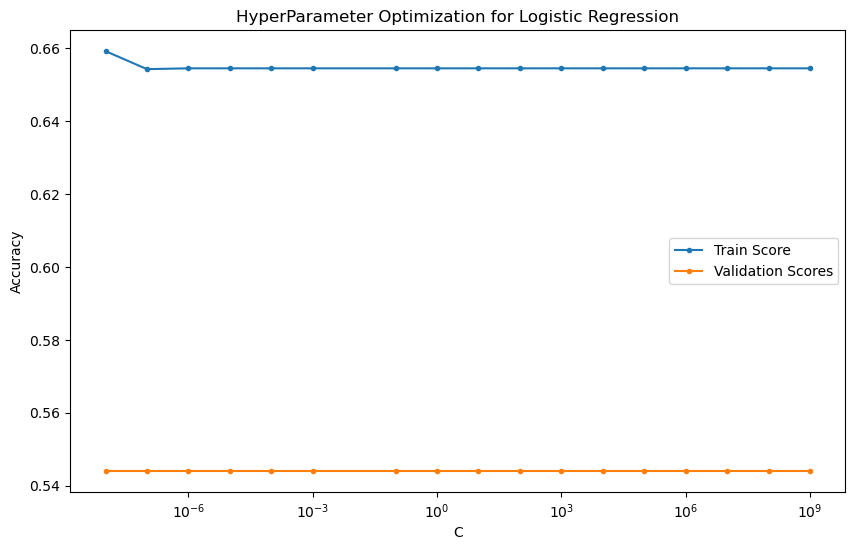

In [64]:
# initiating the plot
plt.figure(figsize=(10, 6))
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('HyperParameter Optimization for Logistic Regression')
plt.legend()
plt.show();

In [65]:
# Get class predictions
y_pred = Logistic_Reg_balanced.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-peak", "Predicted Peak"],
    index=["True Non-Peak", "True Peak Price"]
)

display(cf_df)

,Predicted Non-peak,Predicted Peak
True Non-Peak,933,649
True Peak Price,35,135


Right! So Hyperparameter optimization has not improved our predictive capability. 

<hr>

We know that Logistic Regression is not the best tool at our disposal. So, instead of spending more time optimizing this method, we are going to move on to Decision Trees, and Random Forests, hoping to achieve much bettwe results!

Next Notebook will be notebook 05, titled: Decision Trees.

<hr>

End of notebook Four.